In [1]:
# %pip install datasets

# How To Use HuggingFace Datasets With MLX Streams

# TLDR

In [2]:
import time
from typing import Dict, Any
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import mlx.core as mx
import mlx.data as dx

# Convert the Hugging Face dataset to the custom format
def huggingface_to_array_of_dict(dataset):    
    return [{"image": np.array(image).copy(), "label": label}
            for label, image in zip(dataset['label'], dataset['image'])]

# Convert the Hugging Face dataset to a stream of batches
def hf_dataset_to_mlx_stream(dataset, shuffle=False, bs=256, prefetch_size=4, num_threads=4):
    buffer = dx.buffer_from_vector(huggingface_to_array_of_dict(dataset))
    if shuffle:
        buffer = buffer.shuffle()
    
    return (
        buffer
        .to_stream()
        .key_transform("image", lambda x: x.astype("float32").reshape(-1) / 255) # flat tensor because we gonna use a MLP model      
        .batch(bs)
        .prefetch(prefetch_size, num_threads) # fetch batches in background threads
    )

# Load the MNIST dataset from Hugging Face
ds = load_dataset("ylecun/mnist")

# Transform the dataset to streams
train_stream = hf_dataset_to_mlx_stream(ds['train'], shuffle=True)

# Iterate on the batches
train_stream.reset()
for batch_counter, batch in enumerate(train_stream):
    (X, y) = mx.array(batch['image']), mx.array(batch['label'])

    print('The image has shape ', X[0].shape)    
    print('The image should display a ', y[0].item())
    break


The image has shape  (784,)
The image should display a  8


In [3]:
ds['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

# From Dataset To MLX Streams

### Create a Config To Keep Config/HyperParams Organized

In [4]:
cfg = SimpleNamespace()

### Load dataset and Split

We’ll use only the training set for now, splitting it into two parts:
- Training Set: 80% for training our model.
- Validation Set: 20% for checking the model’s accuracy at each epoch.

We’ll keep the test set aside for the final evaluation to see how our model performs on completely unseen data.

In [5]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")
split_ds = ds['train'].train_test_split(test_size=0.2)
ds = {
    'train': split_ds['train'],
    'val': split_ds['test'],
    'test': ds['test']
}

In [6]:
type(ds['train']['image'][0])

PIL.PngImagePlugin.PngImageFile

Our mission is to turn this into a mx.array

### From Hugging Face Dataset To MLX Streams

In [7]:
import numpy as np
import mlx.data as dx

# Convert the content of the dataset into numpy arrays
def huggingface_to_array_of_dict(dataset):    
    return [{"image": np.array(image).copy(), "label": label}
            for label, image in zip(dataset['label'], dataset['image'])]

# Convert the Hugging Face dataset to a stream of batches
def hf_dataset_to_mlx_stream(dataset, shuffle=False, bs=256, prefetch_size=4, num_threads=4):
    numpy_data = huggingface_to_array_of_dict(dataset)

    # This might look tedious but these little assert will save you a lot of time
    assert type(numpy_data) == list, "Processed data should be a list"
    assert len(numpy_data) == len(dataset), "Output length should match input length"
    assert type(numpy_data[0]) == dict, "Each item should be a dictionary"
    assert 'image' in numpy_data[0] and 'label' in numpy_data[0], "Each dict should have 'image' and 'label' keys"
    assert type(numpy_data[0]['image']) == np.ndarray, f"{type(numpy_data[0]['image'])} should be a numpy array"

    buffer = dx.buffer_from_vector(numpy_data)
    if shuffle:
        buffer = buffer.shuffle()    
    
    return (
        buffer
        .to_stream()
        .key_transform("image", lambda x: x.astype("float32").reshape(-1) / 255) # flat tensor because we gonna use a MLP model      
        .batch(bs)
        .prefetch(prefetch_size, num_threads) # fetch batches in background threads
    )

### Keeping Params Oganized

In [8]:
from types import SimpleNamespace

cfg = SimpleNamespace()
# These are more Loading Param
cfg.prefetch = 4
cfg.num_threads = 8
cfg.batch_size = 256

In [9]:
train_stream = hf_dataset_to_mlx_stream(ds['train'],
                                        shuffle=True,
                                        bs=cfg.batch_size,
                                        prefetch_size=cfg.prefetch,
                                        num_threads=cfg.num_threads)
train_stream

Stream()

### Finally We Can Iterate On The Streams

The image should display a  9


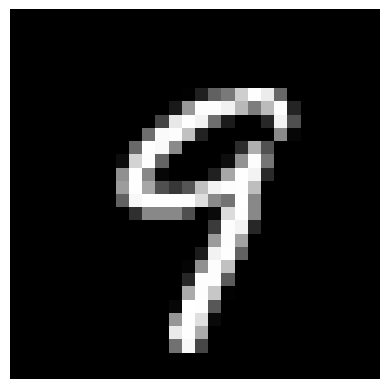

epoch time: 0.05062 (s)


In [11]:
# helper to display an image
import matplotlib.pyplot as plt
import time

def np_show_img(array, title=''):
    if array.ndim == 1:  # If rank 1, reshape to 2D
        array = array.reshape(28, 28)
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()

def one_epoch():
    train_stream.reset()
    for batch in train_stream:    
        (X, y) = mx.array(batch['image']), mx.array(batch['label'])
        
        # we want a flat tensor (batch_size,pixels) since we gonna use a MLP instead of a CNN
        assert X.ndim == 2, X.shape
        assert X.shape == (cfg.batch_size, 784), X.shape
        assert X.dtype == mx.float32, X.dtype
        assert y.shape == (cfg.batch_size,), y.shape
            
        print('The image should display a ', y[0].item())
        np_show_img(X[0])
        break # USE OPTIMIZER HERE

# ADD YOUR EPOCH LOOP, ETC HERE
tic = time.perf_counter()
one_epoch()
toc = time.perf_counter()
print(f"epoch time: {toc - tic:.5f} (s)")